In [1]:
# Import libraries
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.linear_model import Ridge, Lasso
from sklearn.metrics import mean_squared_error, make_scorer
from scipy.stats import spearmanr
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Import Data
from google.colab import drive
drive.mount('/content/drive')
path='/content/drive/MyDrive/Data Challenge /QRT 2023/'
X_train = pd.read_csv(path+'X_train.csv')
Y_train = pd.read_csv(path+'Y_train.csv')
X_test = pd.read_csv(path+'X_test.csv')
# Merge the datasets for easier handling
data = pd.merge(X_train, Y_train, on="ID")
data

Mounted at /content/drive


,ID,DAY_ID,COUNTRY,DE_CONSUMPTION,FR_CONSUMPTION,DE_FR_EXCHANGE,FR_DE_EXCHANGE,DE_NET_EXPORT,FR_NET_EXPORT,DE_NET_IMPORT,...,DE_RAIN,FR_RAIN,DE_WIND,FR_WIND,DE_TEMP,FR_TEMP,GAS_RET,COAL_RET,CARBON_RET,TARGET
0,1054,206,FR,0.210099,-0.427458,-0.606523,0.606523,NaN,0.692860,NaN,...,-0.172680,-0.556356,-0.790823,-0.283160,-1.069070,-0.063404,0.339041,0.124552,-0.002445,0.028313
1,2049,501,FR,-0.022399,-1.003452,-0.022063,0.022063,-0.573520,-1.130838,0.573520,...,-1.240300,-0.770457,1.522331,0.828412,0.437419,1.831241,-0.659091,0.047114,-0.490365,-0.112516
2,1924,687,FR,1.395035,1.978665,1.021305,-1.021305,-0.622021,-1.682587,0.622021,...,-0.480700,-0.313338,0.431134,0.487608,0.684884,0.114836,0.535974,0.743338,0.204952,-0.180840
3,297,720,DE,-0.983324,-0.849198,-0.839586,0.839586,-0.270870,0.563230,0.270870,...,-1.114838,-0.507570,-0.499409,-0.236249,0.350938,-0.417514,0.911652,-0.296168,1.073948,-0.260356
4,1101,818,FR,0.143807,-0.617038,-0.924990,0.924990,NaN,0.990324,NaN,...,-0.541465,-0.424550,-1.088158,-1.011560,0.614338,0.729495,0.245109,1.526606,2.614378,-0.071733
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1489,459,809,DE,1.529204,1.106682,-1.855327,1.855327,-0.218658,1.450426,0.218658,...,NaN,NaN,NaN,NaN,NaN,NaN,0.876984,0.819520,1.320373,-0.172597
1490,1674,887,FR,1.618582,1.752840,0.611392,-0.611392,0.449153,-0.152146,-0.449153,...,NaN,NaN,NaN,NaN,NaN,NaN,0.932633,-0.085690,0.356356,-0.063546
1491,748,1083,DE,0.856399,0.489199,-0.255778,0.255778,-1.531544,-0.829568,1.531544,...,0.207905,0.404763,-0.594595,0.894011,0.256338,0.402316,-1.112899,-0.237835,0.067152,0.151797
1492,1454,1133,FR,0.560689,-0.343777,-0.830239,0.830239,-0.304856,1.210230,0.304856,...,-0.682815,-0.390304,-0.972088,-1.501930,1.215528,1.338708,0.962812,-5.392852,-0.843812,-0.640917


# Data Preprocessing

In [3]:
"""# Descriptive Analysis of Quantitative Variables"""

# Filter data for Germany only
data = data[data['COUNTRY'] == 'DE']

# Select variables of interest
features = [
    'DE_CONSUMPTION', 'FR_CONSUMPTION',
    'DE_FR_EXCHANGE', 'FR_DE_EXCHANGE', 'DE_NET_EXPORT', 'FR_NET_EXPORT',
    'DE_NET_IMPORT', 'FR_NET_IMPORT', 'DE_GAS', 'FR_GAS', 'DE_COAL',
    'FR_COAL', 'DE_HYDRO', 'FR_HYDRO', 'DE_NUCLEAR', 'FR_NUCLEAR',
    'DE_SOLAR', 'FR_SOLAR', 'DE_WINDPOW', 'FR_WINDPOW', 'DE_LIGNITE',
    'DE_RESIDUAL_LOAD', 'FR_RESIDUAL_LOAD', 'DE_RAIN', 'FR_RAIN', 'DE_WIND',
    'FR_WIND', 'DE_TEMP', 'FR_TEMP', 'GAS_RET', 'COAL_RET', 'CARBON_RET',
    'ID', 'TARGET'
]

# Select the variables
data = data[features]
data.head()

,DE_CONSUMPTION,FR_CONSUMPTION,DE_FR_EXCHANGE,FR_DE_EXCHANGE,DE_NET_EXPORT,FR_NET_EXPORT,DE_NET_IMPORT,FR_NET_IMPORT,DE_GAS,FR_GAS,...,FR_RAIN,DE_WIND,FR_WIND,DE_TEMP,FR_TEMP,GAS_RET,COAL_RET,CARBON_RET,ID,TARGET
3,-0.983324,-0.849198,-0.839586,0.839586,-0.270870,0.563230,0.270870,-0.563230,0.487818,0.194659,...,-0.507570,-0.499409,-0.236249,0.350938,-0.417514,0.911652,-0.296168,1.073948,297,-0.260356
11,-0.055692,-0.811337,0.237105,-0.237105,-0.851082,-1.091142,0.851082,1.091142,0.882313,-0.145637,...,2.014508,1.143607,1.777992,1.595158,0.158463,-0.359866,-0.203952,-0.376234,819,-0.133381
12,0.532116,-0.331101,0.339942,-0.339942,-0.173123,-1.312029,0.173123,1.312029,-0.188430,1.382599,...,-1.394500,1.383171,0.100498,1.241892,-0.206340,1.170760,0.133643,0.033874,918,0.196312
13,-0.328286,-1.062255,-1.380464,1.380464,-1.046122,1.002243,1.046122,-1.002243,0.544008,-0.730992,...,-0.069416,-0.138918,-0.695013,-0.634046,-0.168491,0.122818,0.220077,5.453331,283,-0.025477
14,1.028987,1.629315,1.129663,-1.129663,-0.391261,-1.823117,0.391261,1.823117,2.170761,2.122272,...,-0.516738,-1.106067,-0.945562,-0.667496,-1.566773,0.689483,1.095473,0.342798,158,0.460278


In [4]:
# Display descriptive statistics
print("Descriptive Statistics:")
print(data.describe())

Descriptive Statistics:
       DE_CONSUMPTION  FR_CONSUMPTION  DE_FR_EXCHANGE  FR_DE_EXCHANGE  \
count      643.000000      643.000000      643.000000      643.000000   
mean         0.379809       -0.091154       -0.172616        0.172616   
std          0.682092        0.881826        0.988550        0.988550   
min         -2.265563       -1.462350       -2.856874       -2.634831   
25%         -0.069473       -0.739671       -0.979886       -0.640639   
50%          0.288112       -0.465141       -0.172069        0.172069   
75%          0.895751        0.502994        0.640639        0.979886   
max          2.033851        2.432090        2.634831        2.856874   

       DE_NET_EXPORT  FR_NET_EXPORT  DE_NET_IMPORT  FR_NET_IMPORT      DE_GAS  \
count     643.000000     643.000000     643.000000     643.000000  643.000000   
mean       -0.327798      -0.124726       0.327798       0.124726    0.814385   
std         0.930585       1.093166       0.930585       1.093166    0.8488


Histograms of Quantitative Variables:


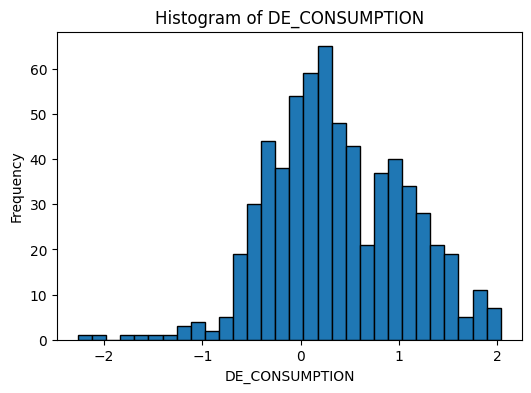

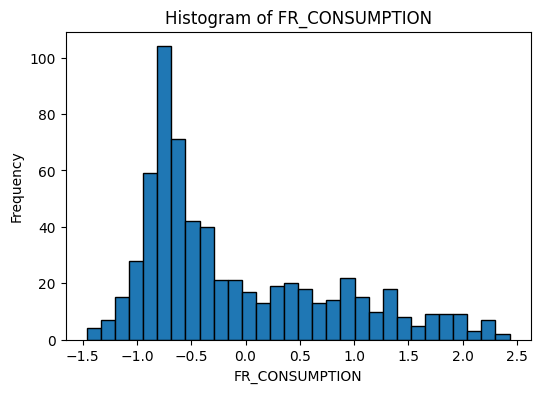

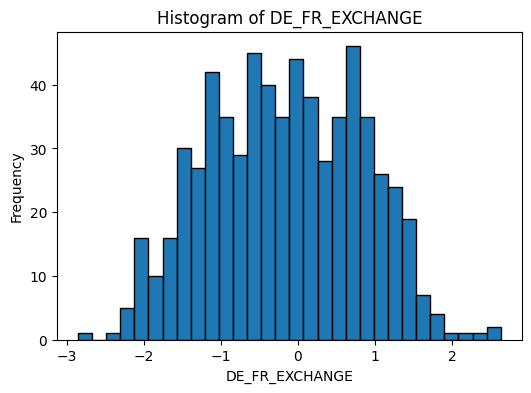

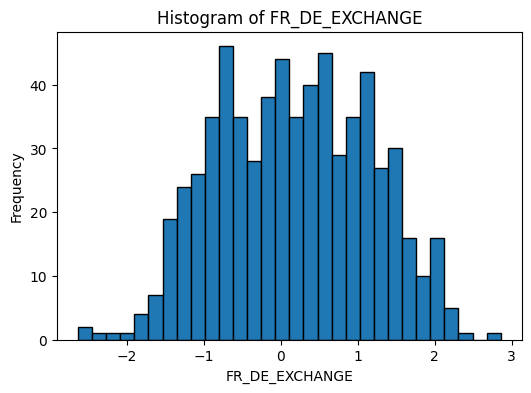

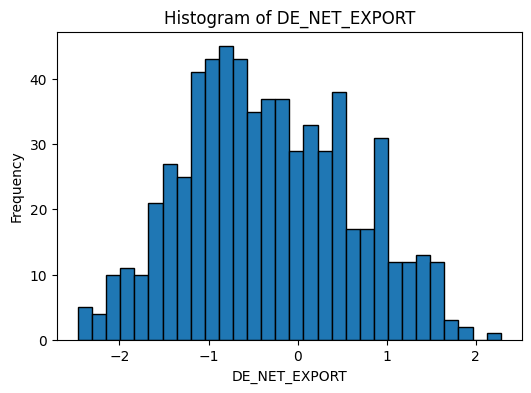

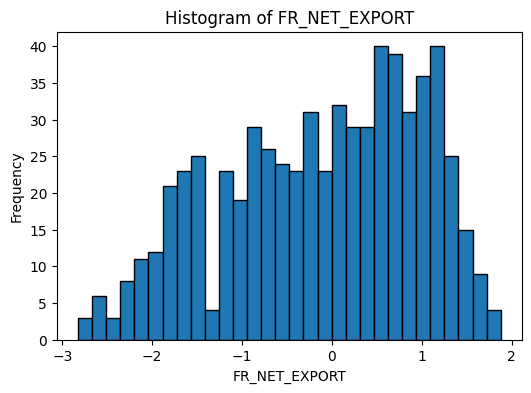

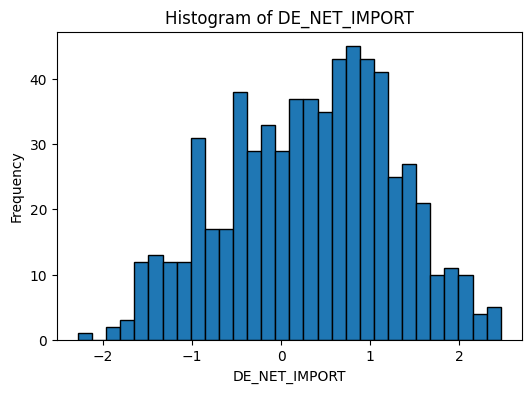

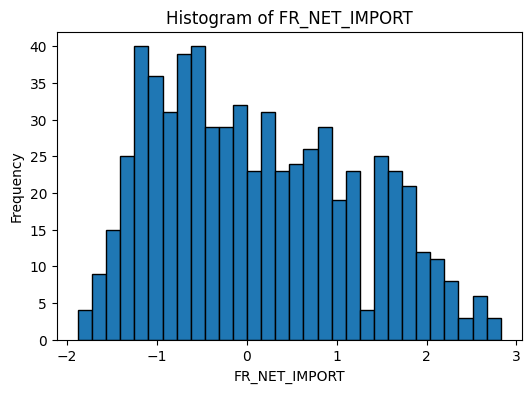

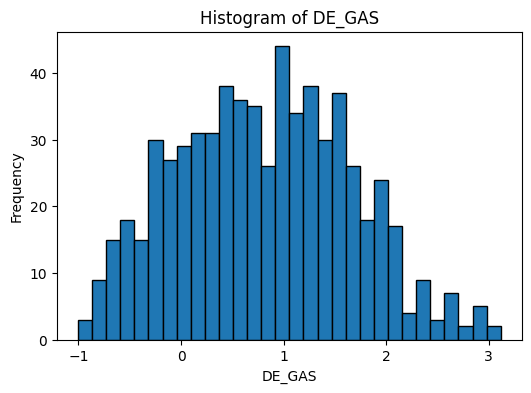

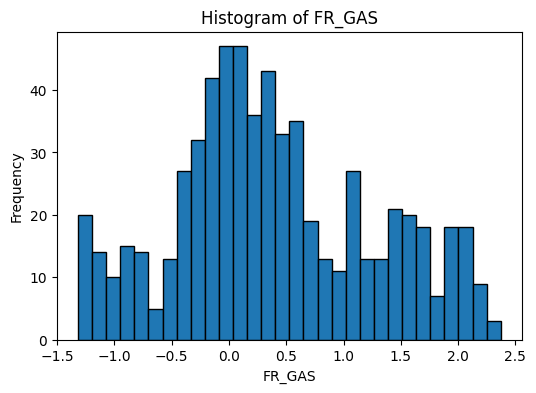

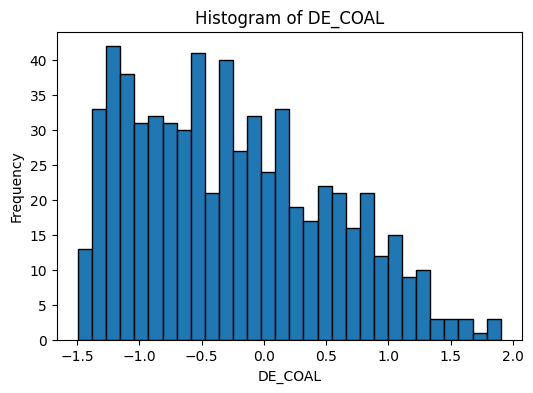

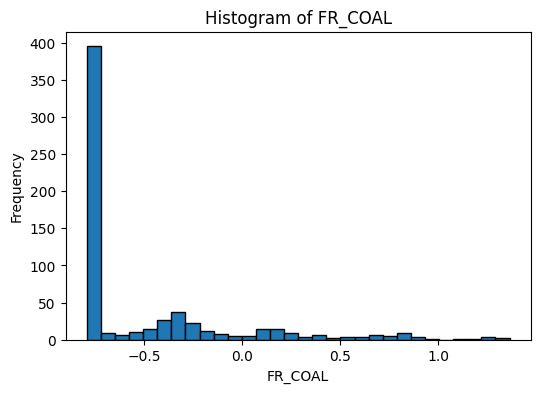

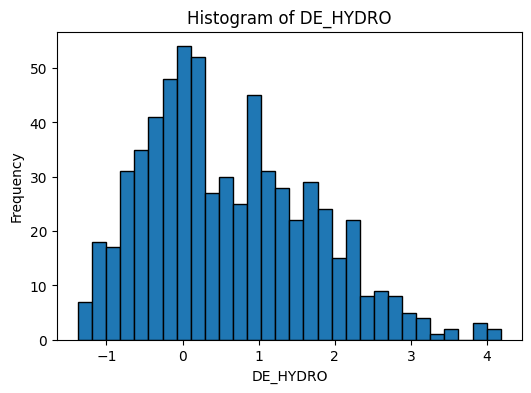

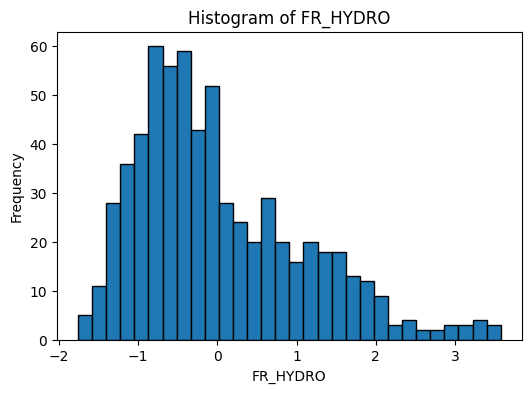

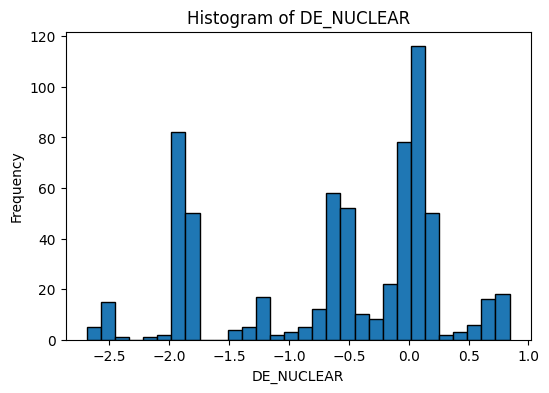

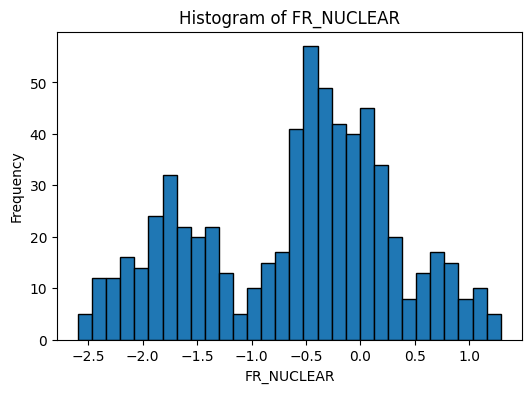

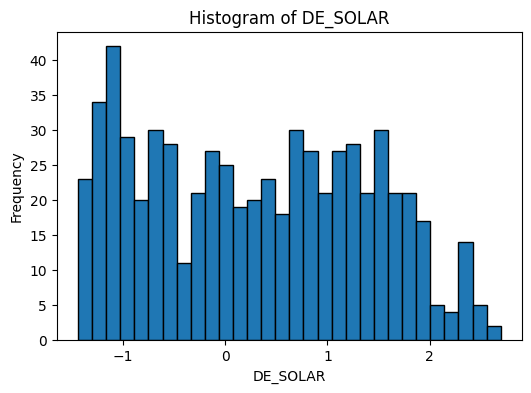

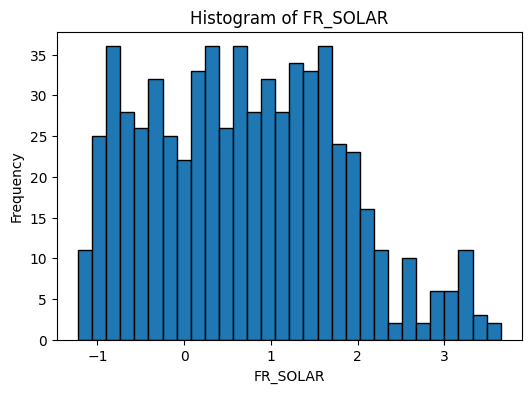

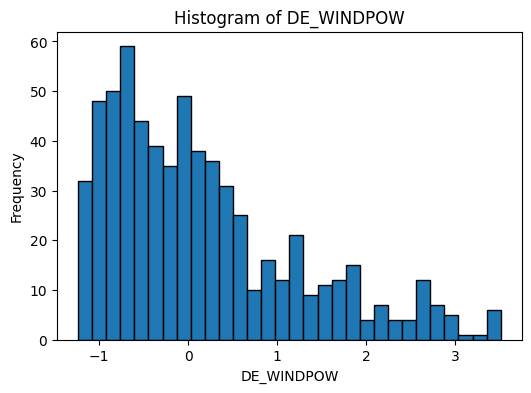

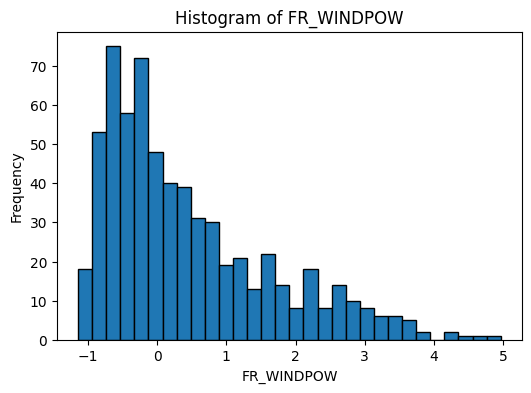

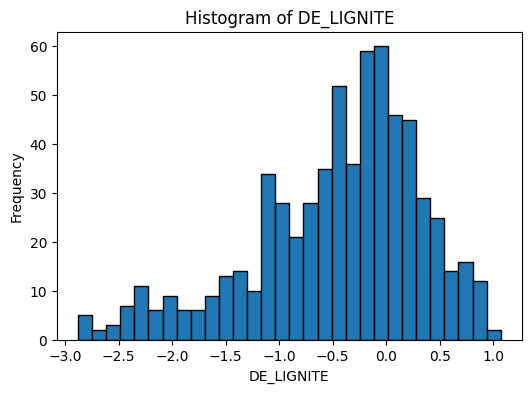

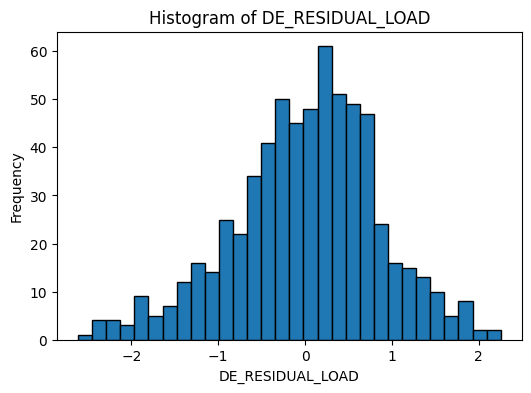

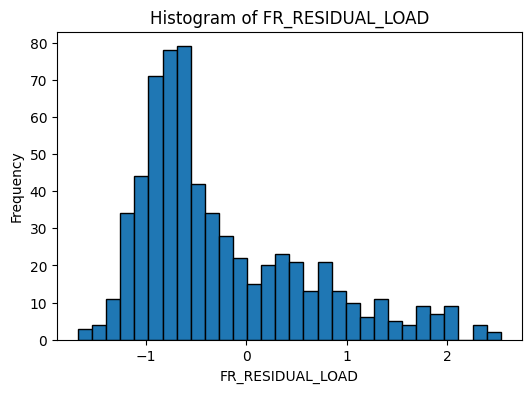

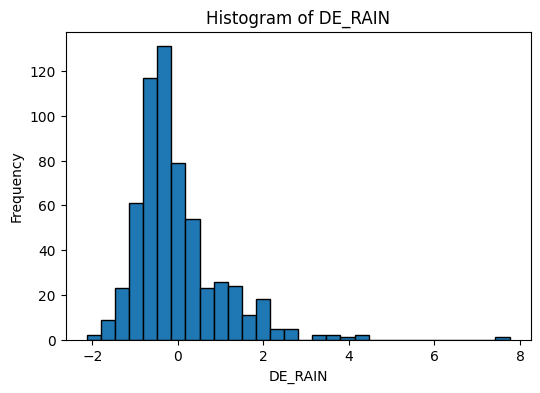

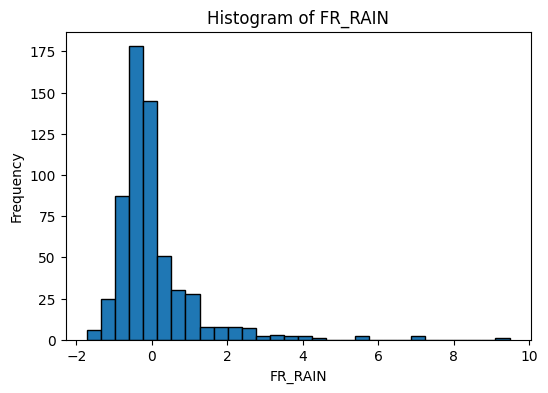

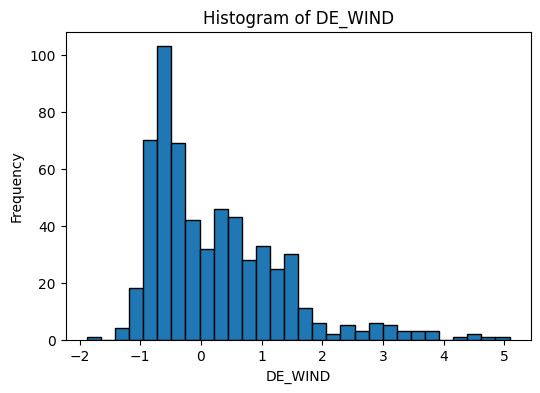

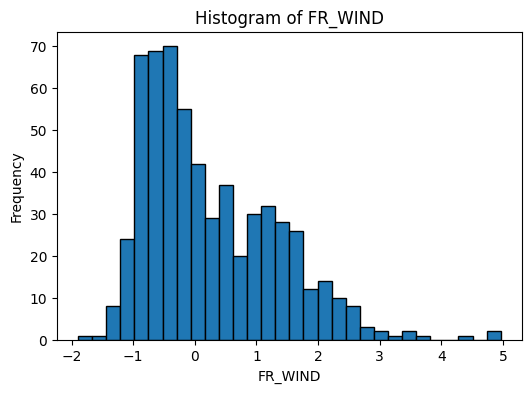

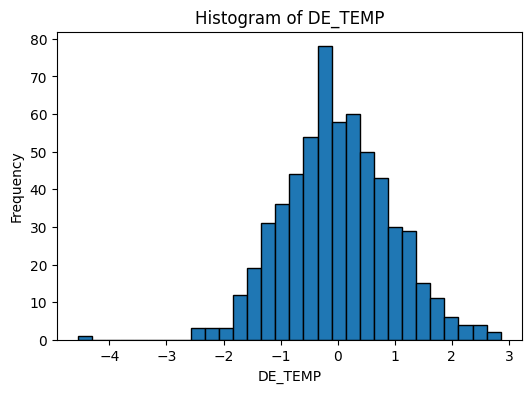

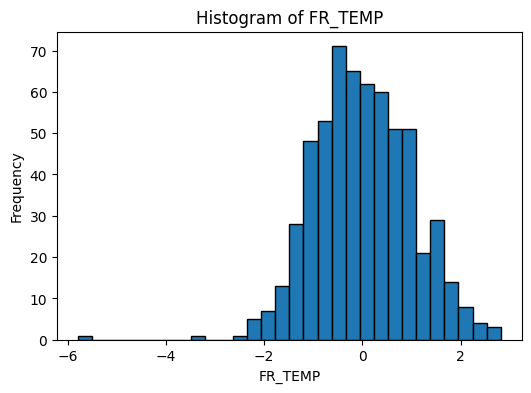

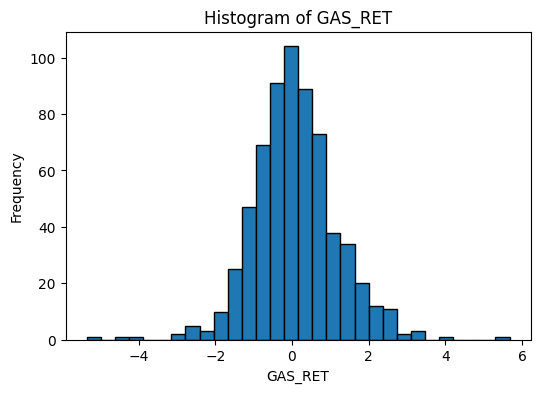

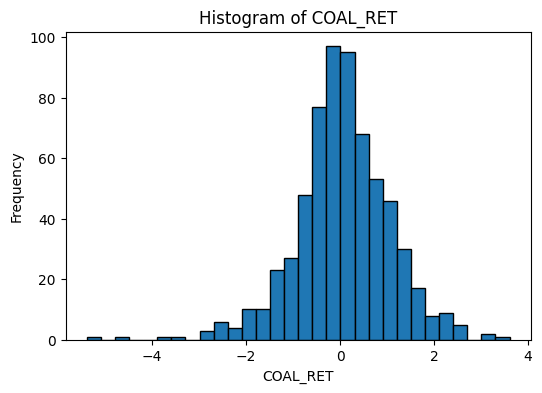

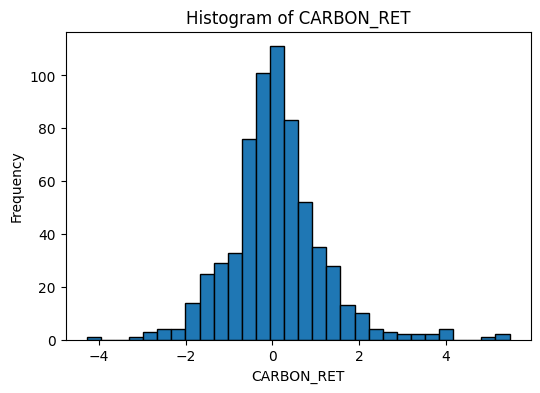

In [7]:
# List of quantitative variables
quantitative_vars = data.select_dtypes(include=['float64', 'int64']).columns.tolist()
quantitative_vars.remove('ID')  # Exclude 'ID' from plots
quantitative_vars.remove('TARGET')  # Exclude 'TARGET' from plots

# Histograms of quantitative variables
print("\nHistograms of Quantitative Variables:")
for var in quantitative_vars:
    plt.figure(figsize=(6, 4))
    plt.hist(data[var].dropna(), bins=30, edgecolor='k')
    plt.title(f"Histogram of {var}")
    plt.xlabel(var)
    plt.ylabel("Frequency")
    plt.show()




Correlation Matrix:


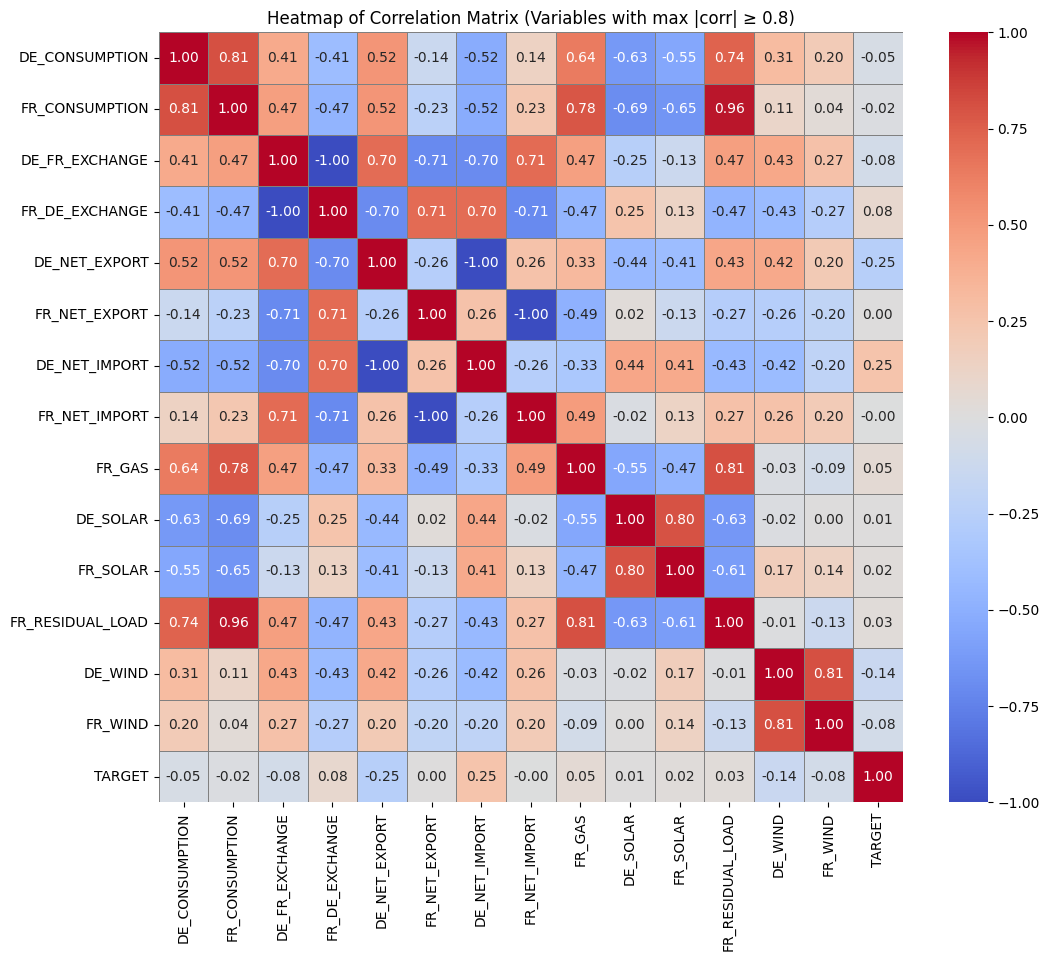

In [6]:
# Correlation matrix with correlation above 0.8 or under -0.8
# Correlation matrix
print("\nCorrelation Matrix:")
corr_matrix = data[quantitative_vars + ['TARGET']].corr()

# Remove variables that only have a self-correlation of 1 and no other correlations above 0.8 or below -0.8
# Compute the maximum absolute correlation for each variable (excluding self-correlation)
corr_without_self = corr_matrix.abs().where(~np.eye(corr_matrix.shape[0], dtype=bool))
max_corr = corr_without_self.max(axis=1)

# Identify variables to keep (max absolute correlation >= 0.8)
variables_to_keep = max_corr[max_corr >= 0.8].index.tolist()

# Ensure 'TARGET' is included
if 'TARGET' not in variables_to_keep:
    variables_to_keep.append('TARGET')

# Filter the correlation matrix
filtered_corr_matrix = corr_matrix.loc[variables_to_keep, variables_to_keep]

# Display filtered correlation matrix as a heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(filtered_corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', vmin=-1, vmax=1, linewidths=0.5, linecolor='gray')
plt.title("Heatmap of Correlation Matrix (Variables with max |corr| ≥ 0.8)")
plt.show()


Boxplots of Quantitative Variables:


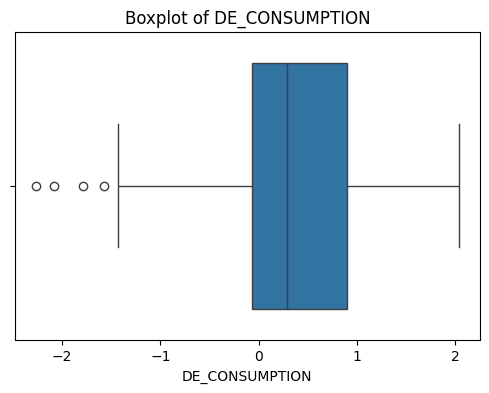

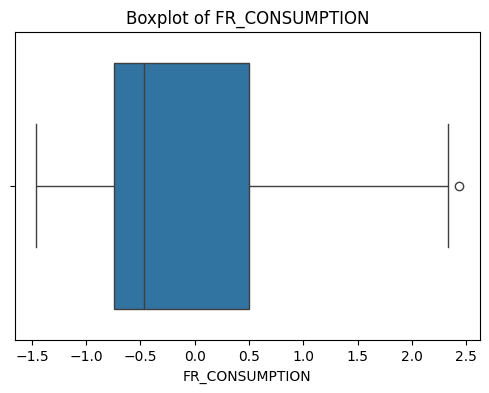

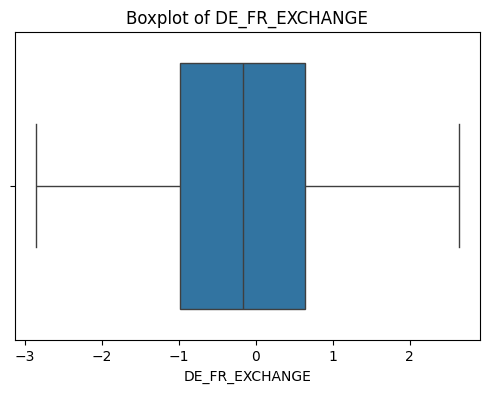

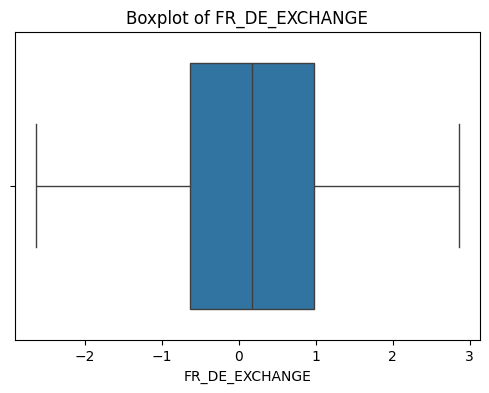

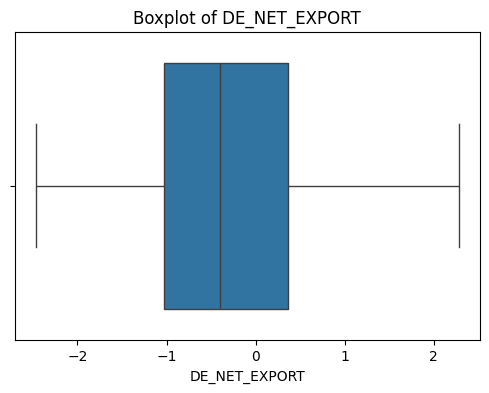

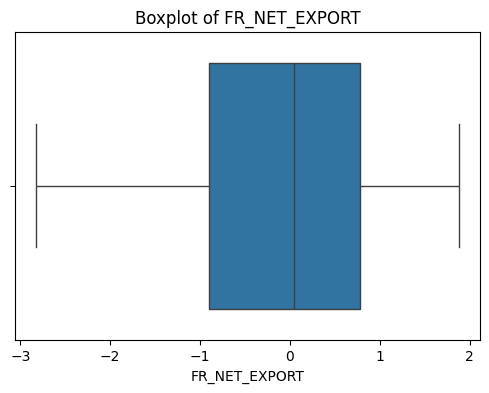

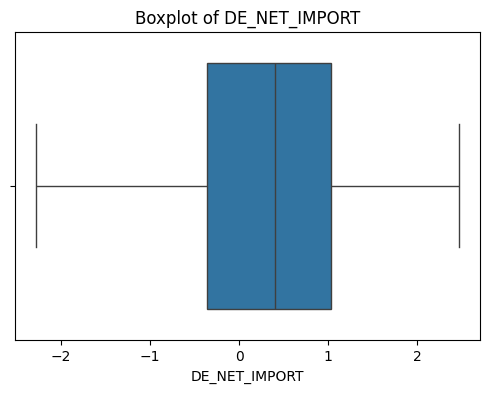

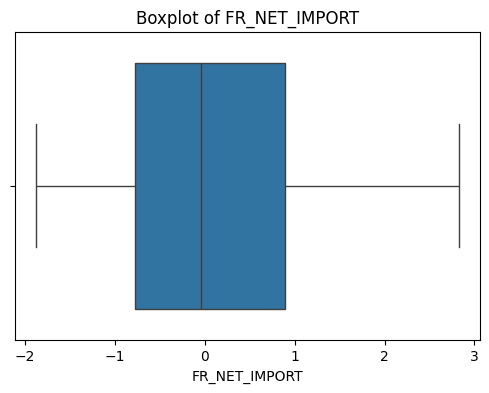

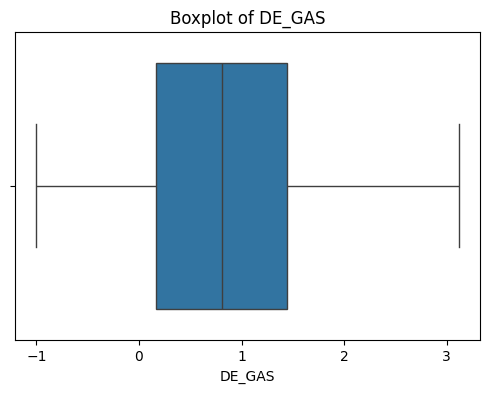

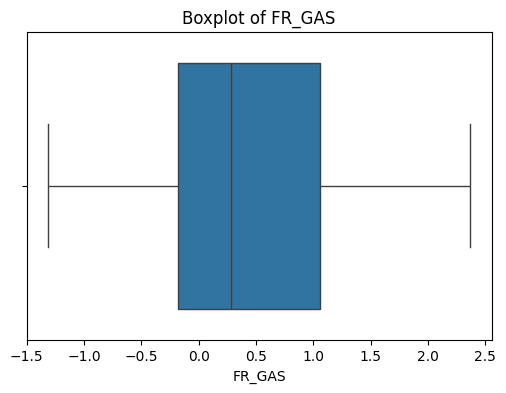

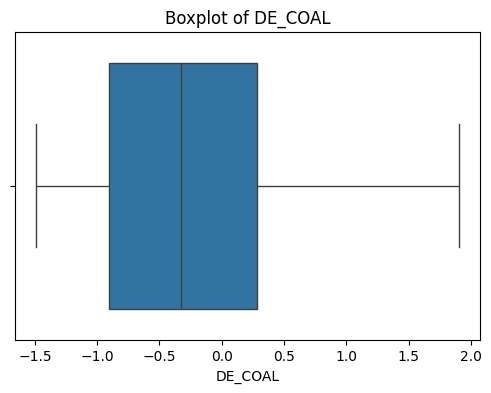

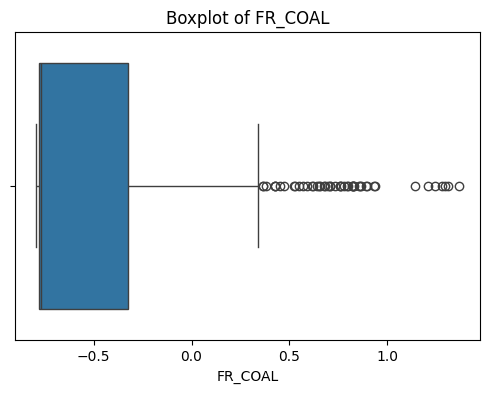

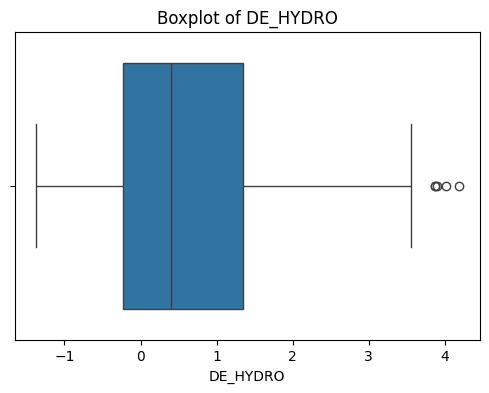

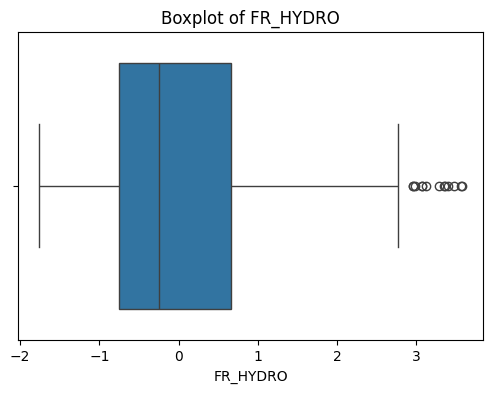

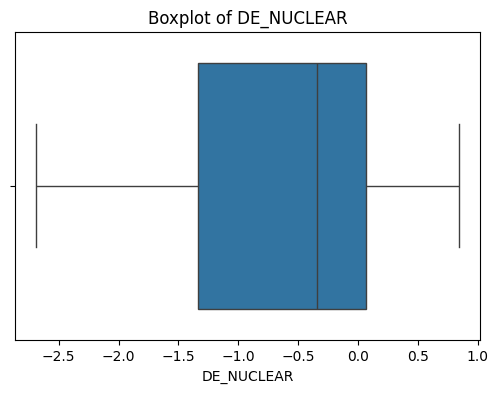

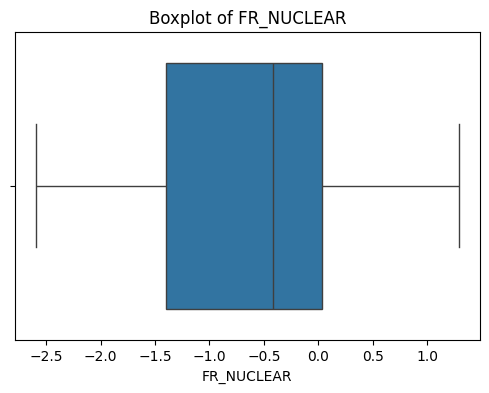

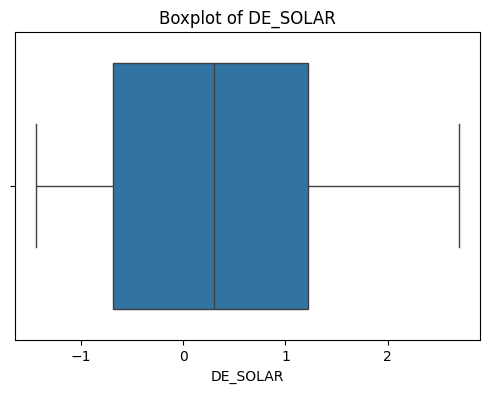

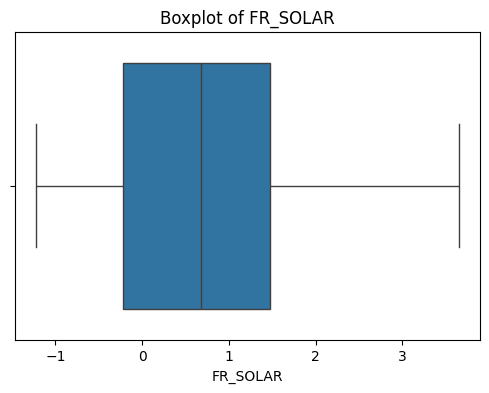

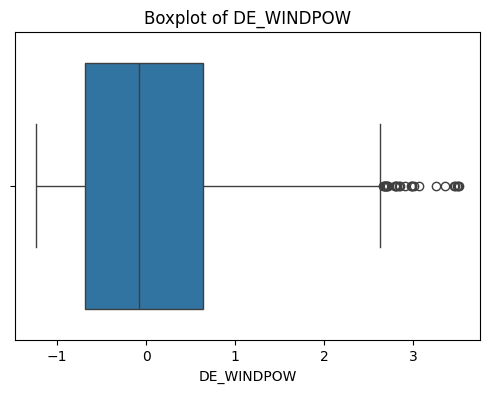

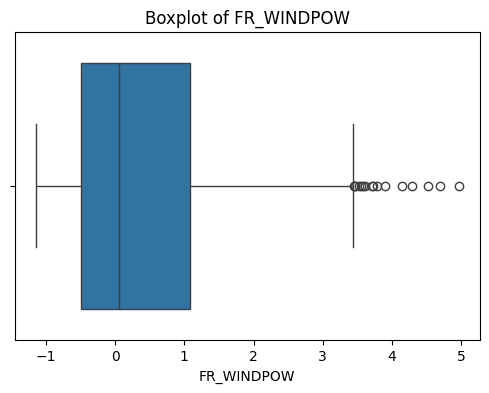

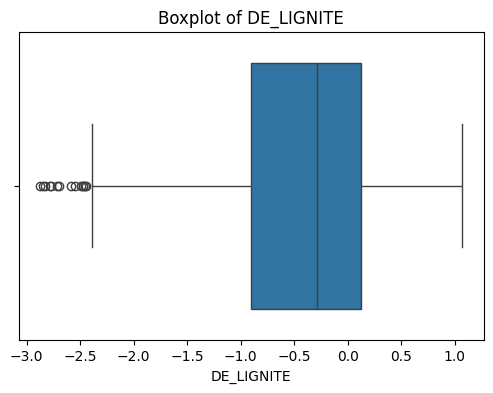

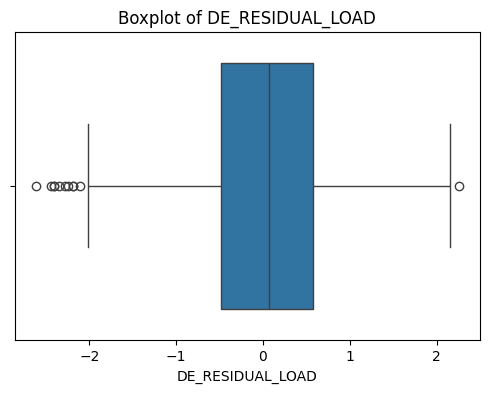

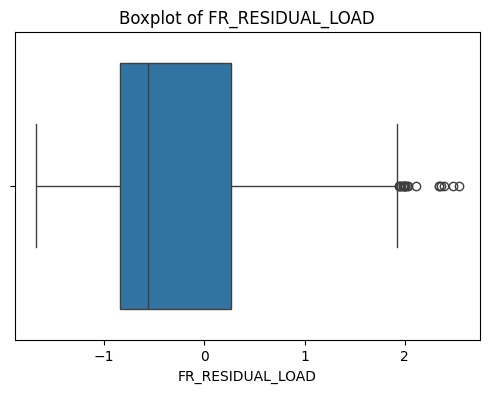

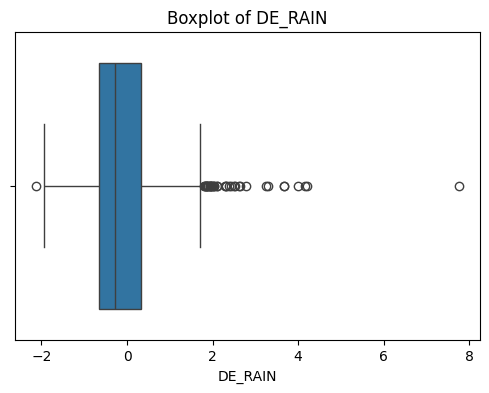

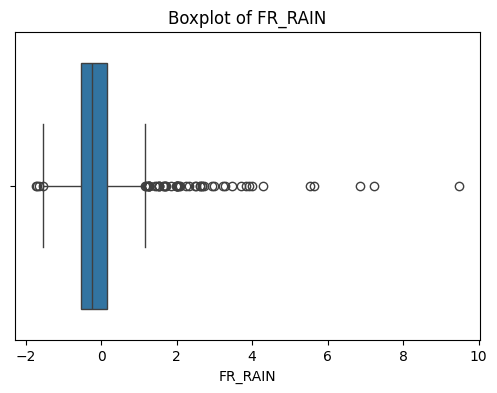

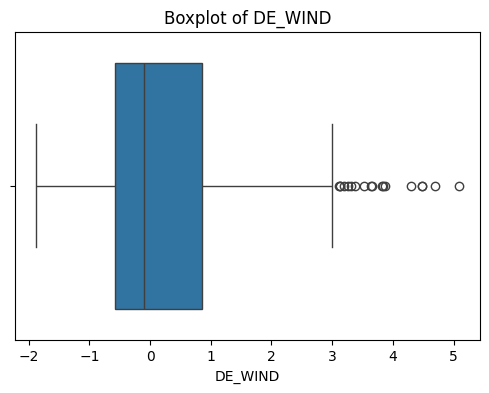

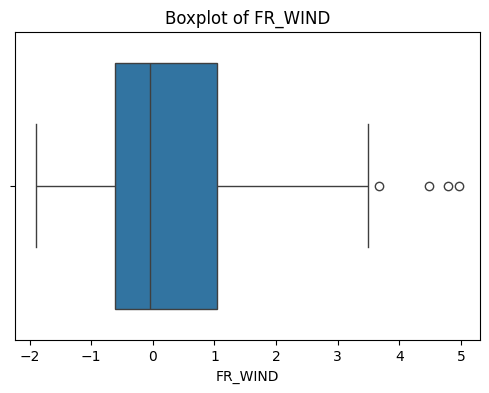

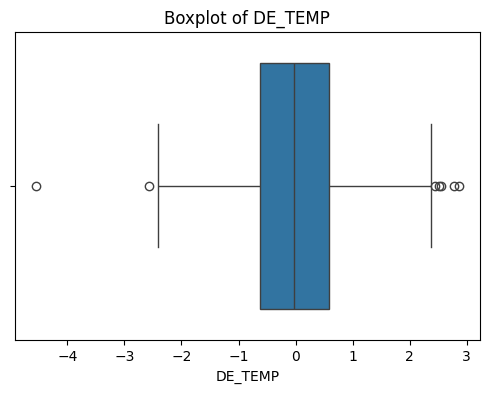

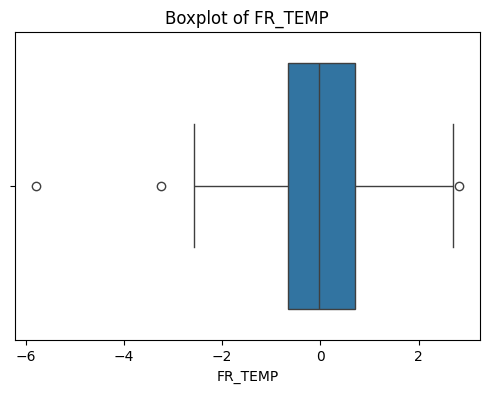

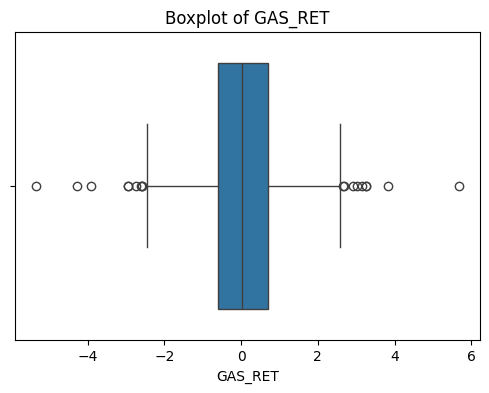

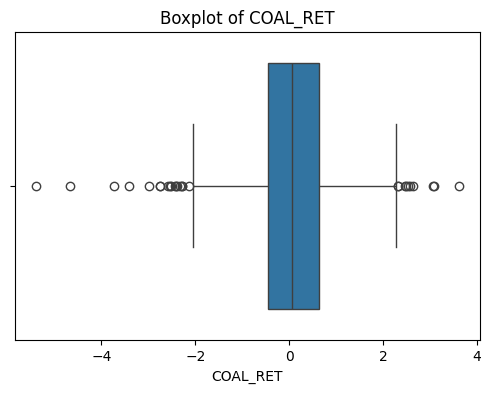

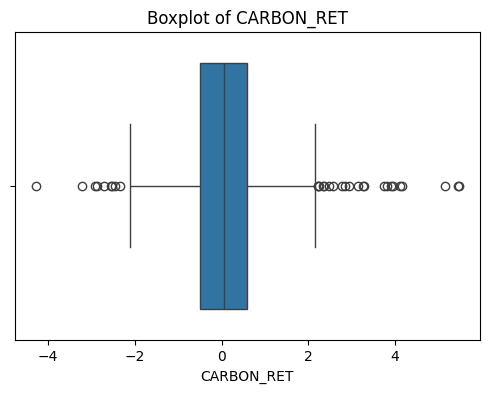

In [8]:
# Boxplots to detect outliers
print("\nBoxplots of Quantitative Variables:")
for var in quantitative_vars:
    plt.figure(figsize=(6, 4))
    sns.boxplot(x=data[var])
    plt.title(f"Boxplot of {var}")
    plt.xlabel(var)
    plt.show()


In [9]:
# Missing values analysis
print("\nMissing Values Analysis:")
missing_values = data.isnull().sum()
print(missing_values[missing_values > 0])


Missing Values Analysis:
DE_RAIN    47
FR_RAIN    47
DE_WIND    47
FR_WIND    47
DE_TEMP    47
FR_TEMP    47
dtype: int64


In [10]:
# Fill missing values with mean
imputer = SimpleImputer(strategy='mean')
data_imputed = pd.DataFrame(imputer.fit_transform(data), columns=features)

# Splitting data into features and target
X = data_imputed.drop(columns=["TARGET", "ID"], errors='ignore')
y = data_imputed["TARGET"]


# Modeling

In [11]:
# Define a custom Spearman correlation scorer
def spearman_correlation(y_true, y_pred):
    return spearmanr(y_true, y_pred).correlation

spearman_scorer = make_scorer(spearman_correlation, greater_is_better=True)

   # Define models and hyperparameters
models = {
    "RandomForest": {
        "model": RandomForestRegressor(random_state=42),
        "params": {
            "n_estimators": [50, 100, 200],
            "max_depth": [None, 10, 20]
        }
    },
    "SVR": {
        "model": SVR(),
        "params": {
            "C": [0.1, 1, 10],
            "kernel": ["linear", "rbf"]
        }
    },
    "Ridge": {
        "model": Ridge(),
        "params": {
            "alpha": [0.1, 1, 10]
        }
    },
    "Lasso": {
        "model": Lasso(),
        "params": {
            "alpha": [0.01, 0.1, 1]
        }
    },
    "XGBoost": {
        "model": XGBRegressor(random_state=42),
        "params": {
            "n_estimators": [50, 100, 200],
            "max_depth": [3, 6, 10],
            "learning_rate": [0.01, 0.1, 0.2]
        }
    }
}


In [12]:
# Train-test split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

Model: RandomForest
Best Parameters: {'max_depth': 10, 'n_estimators': 50}
Spearman Correlation: 0.128

Model: SVR
Best Parameters: {'C': 10, 'kernel': 'linear'}
Spearman Correlation: 0.319

Model: Ridge
Best Parameters: {'alpha': 10}
Spearman Correlation: 0.361

Model: Lasso
Best Parameters: {'alpha': 0.01}
Spearman Correlation: 0.358



<ipython-input-11-2fe69a7033cf>:3: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  return spearmanr(y_true, y_pred).correlation
<ipython-input-11-2fe69a7033cf>:3: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  return spearmanr(y_true, y_pred).correlation
<ipython-input-11-2fe69a7033cf>:3: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  return spearmanr(y_true, y_pred).correlation
<ipython-input-11-2fe69a7033cf>:3: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  return spearmanr(y_true, y_pred).correlation
<ipython-input-11-2fe69a7033cf>:3: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  return spearmanr(y_true, y_pred).correlation
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:1103: UserWarning: One or more of the test sc

Model: XGBoost
Best Parameters: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}
Spearman Correlation: 0.137



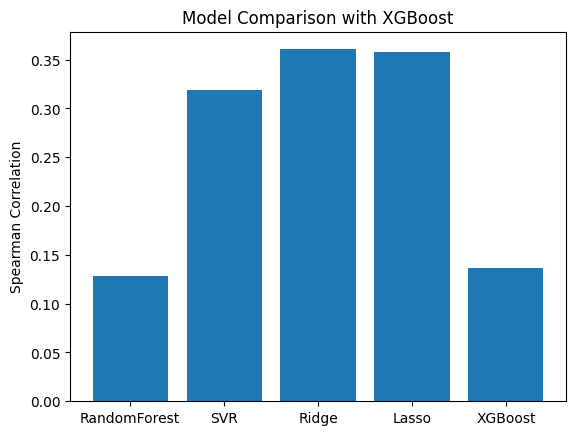

In [13]:
# Training and evaluating models
results = {}

for model_name, mp in models.items():
    grid_search = GridSearchCV(mp["model"], mp["params"], cv=5, scoring=spearman_scorer)
    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_val)

    # Evaluate with Spearman Correlation
    spearman_corr = spearman_correlation(y_val, y_pred)
    results[model_name] = {"best_params": grid_search.best_params_, "spearman_corr": spearman_corr}
    print(f"Model: {model_name}")
    print(f"Best Parameters: {grid_search.best_params_}")
    print(f"Spearman Correlation: {spearman_corr:.3f}\n")

# Visualizing results including XGBoost
plt.bar(results.keys(), [r["spearman_corr"] for r in results.values()])
plt.ylabel("Spearman Correlation")
plt.title("Model Comparison with XGBoost")
plt.show()


In [ ]:

# Generate predictions for the test set with the best model
best_model_name = max(results, key=lambda k: results[k]["spearman_corr"])
best_model_params = results[best_model_name]["best_params"]
print(f"The best model is {best_model_name} with a Spearman correlation of {results[best_model_name]['spearman_corr']:.3f}")

# Retrain the best model on the entire training data
best_model = models[best_model_name]["model"].set_params(**best_model_params)
best_model.fit(X, y)

"""# Preparing the Submission File"""

# Prepare the test data
X_test_preprocessed = X_test.copy()


# Select the same variables as for training
X_test_preprocessed = X_test_preprocessed[features[:-2]]  # Exclude 'ID' and 'TARGET'

# Handle missing values in test data
X_test_imputed = pd.DataFrame(imputer.transform(X_test_preprocessed), columns=X_test_preprocessed.columns)

# Predictions on test data
test_predictions = best_model.predict(X_test_imputed.drop(columns=['ID'], errors='ignore'))

# Prepare the submission file
submission = pd.DataFrame({"ID": X_test_preprocessed["ID"], "TARGET": test_predictions})

# Save the submission file
submission.to_csv("submissionDEV10.csv", index=False)
print("Submission : submissionDEV10.csv")
submission